# Autoregressive Models

In [1]:
# Activate local environment, see `Project.toml`
import Pkg; Pkg.activate(".."); Pkg.instantiate(); 

  Activating project at `~/.julia/dev/RxInfer.jl/examples`


In this example we are going to perform an automated Variational Bayesian Inference for a latent autoregressive model that can be represented as following:

$$\begin{aligned}
p(\gamma) &= \mathrm{Gamma}(\gamma|a, b),\\
p(\mathbf{\theta}) &= \mathcal{N}(\mathbf{\theta}|\mathbf{\mu}, \Sigma),\\
p(x_t|\mathbf{x}_{t-1:t-k}) &= \mathcal{N}(x_t|\mathbf{\theta}^{T}\mathbf{x}_{t-1:t-k}, \gamma^{-1}),\\
p(y_t|x_t) &= \mathcal{N}(y_t|x_t, \tau^{-1}),
\end{aligned}$$

where $x_t$ is a current state of our system, $\mathbf{x}_{t-1:t-k}$ is a sequence of $k$ previous states, $k$ is an order of autoregression process, $\mathbf{\theta}$ is a vector of transition coefficients, $\gamma$ is a precision of state transition process, $y_k$ is a noisy observation of $x_k$ with precision $\tau$.

For a more rigorous introduction to Bayesian inference in Autoregressive models we refer to [Albert Podusenko, Message Passing-Based Inference for Time-Varying Autoregressive Models](https://www.mdpi.com/1099-4300/23/6/683).

We start with importing all needed packages:

In [2]:
using RxInfer, Distributions, LinearAlgebra, Random, Plots, BenchmarkTools, Parameters

Let's generate some synthetic dataset, we use a predefined sets of coeffcients for $k$ = 1, 3 and 5 respectively:

In [3]:
# The following coefficients correspond to stable poles
coefs_ar_1 = [-0.27002517200218096]
coefs_ar_2 = [0.4511170798064709, -0.05740081602446657]
coefs_ar_5 = [0.10699399235785655, -0.5237303489793305, 0.3068897071844715, -0.17232255282458891, 0.13323964347539288];

In [4]:
function generate_ar_data(rng, n, θ, γ, τ)
    order        = length(θ)
    states       = Vector{Vector{Float64}}(undef, n + 3order)
    observations = Vector{Float64}(undef, n + 3order)
    
    γ_std = sqrt(inv(γ))
    τ_std = sqrt(inv(τ))
    
    states[1] = randn(rng, order)
    
    for i in 2:(n + 3order)
        states[i]       = vcat(rand(rng, Normal(dot(θ, states[i - 1]), γ_std)), states[i-1][1:end-1])
        observations[i] = rand(rng, Normal(states[i][1], τ_std))
    end
    
    return states[1+3order:end], observations[1+3order:end]
end

generate_ar_data (generic function with 1 method)

In [5]:
# Seed for reproducibility
seed = 123
rng  = MersenneTwister(seed)

# Number of observations in synthetic dataset
n = 500

# AR process parameters
real_γ = 1.0
real_τ = 0.5
real_θ = coefs_ar_5

states, observations = generate_ar_data(rng, n, real_θ, real_γ, real_τ);

Let's plot our synthetic dataset:

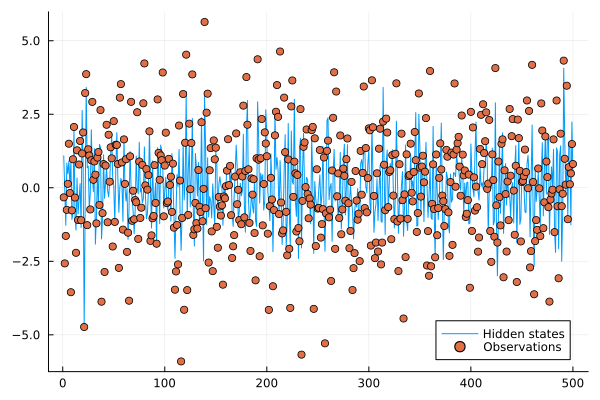

In [6]:
plot(first.(states), label = "Hidden states")
scatter!(observations, label = "Observations")

Next step is to specify probabilistic model, inference constraints and run inference procedure with `RxInfer`. We will specify two different models for Multivariate AR with order $k$ > 1 and for Univariate AR (reduces to simple State-Space-Model) with order $k$ = 1.

In [7]:
@model function lar_model(T::Type, n, order, c, τ)
    
     
    # We create a sequence of random variables for hidden states
    x = randomvar(n)
    # As well a sequence of observartions
    y = datavar(Float64, n)
    
    ct = constvar(c)
    # We assume observation noise to be known
    cτ = constvar(τ)
    
    γ  = randomvar()
    θ  = randomvar()
    x0 = randomvar()
    
    # Prior for first state
    if T === Multivariate
        γ  ~ Gamma(α = 1.0, β = 1.0)
        θ  ~ MvNormal(μ = zeros(order), Λ = diageye(order))
        x0 ~ MvNormal(μ = zeros(order), Λ = diageye(order))
    else
        γ  ~ Gamma(α = 1.0, β = 1.0)
        θ  ~ Normal(μ = 0.0, γ = 1.0)
        x0 ~ Normal(μ = 0.0, γ = 1.0)
    end
    
    x_prev = x0
    
    for i in 1:n
        
        x[i] ~ AR(x_prev, θ, γ) 
        
        if T === Multivariate
            y[i] ~ Normal(μ = dot(ct, x[i]), γ = cτ)
        else
            y[i] ~ Normal(μ = ct * x[i], γ = cτ)
        end
        
        x_prev = x[i]
    end

end

In [8]:
@constraints function ar_constraints() 
    q(x0, x, θ, γ) = q(x0, x)q(θ)q(γ)
end

ar_constraints (generic function with 1 method)

In [9]:
@meta function ar_meta(artype, order, stype)
    AR() -> ARMeta(artype, order, stype)
end

ar_meta (generic function with 1 method)

In [10]:
morder  = 5
martype = Multivariate
mc      = ReactiveMP.ar_unit(martype, morder)
mconstraints = ar_constraints()
mmeta        = ar_meta(martype, morder, ARsafe())

moptions = (limit_stack_depth = 100, )

mmodel         = lar_model(martype, length(observations), morder, mc, real_τ)
mdata          = (y = observations, )
minitmarginals = (γ = GammaShapeRate(1.0, 1.0), θ = MvNormalMeanPrecision(zeros(morder), diageye(morder)))
mreturnvars    = (x = KeepLast(), γ = KeepEach(), θ = KeepEach())

# First execution is slow due to Julia's initial compilation 
# Subsequent runs will be faster (benchmarks are below)
mresult = inference(
    model = mmodel, 
    data  = mdata,
    constraints   = mconstraints,
    meta          = mmeta,
    options       = moptions,
    initmarginals = minitmarginals,
    returnvars    = mreturnvars,
    free_energy   = true,
    iterations    = 50, 
    showprogress  = false
);

In [11]:
@unpack x, γ, θ = mresult.posteriors

Dict{Symbol, Vector} with 3 entries:
  :γ => GammaShapeRate{Float64}[GammaShapeRate{Float64}(a=251.0, b=47.5918), Ga…
  :θ => MvNormalWeightedMeanPrecision{Float64, Vector{Float64}, Matrix{Float64}…
  :x => MvNormalWeightedMeanPrecision{Float64, Vector{Float64}, Matrix{Float64}…

We will use different initial marginals depending on type of our AR process

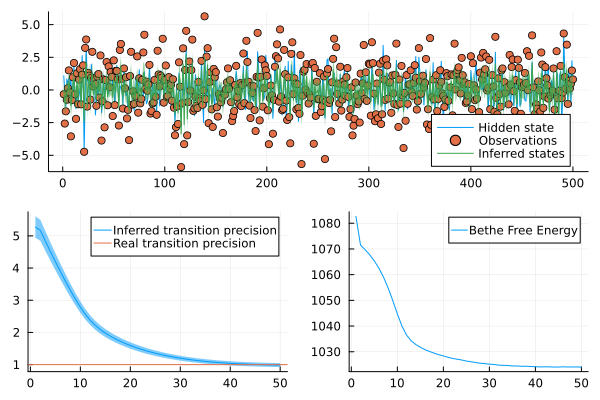

In [12]:
p1 = plot(first.(states), label="Hidden state")
p1 = scatter!(p1, observations, label="Observations")
p1 = plot!(p1, first.(mean.(x)), ribbon = first.(std.(x)), label="Inferred states", legend = :bottomright)

p2 = plot(mean.(γ), ribbon = std.(γ), label = "Inferred transition precision", legend = :topright)
p2 = plot!([ real_γ ], seriestype = :hline, label = "Real transition precision")

p3 = plot(mresult.free_energy, label = "Bethe Free Energy")

plot(p1, p2, p3, layout = @layout([ a; b c ]))

Let's also plot a subrange of our results:

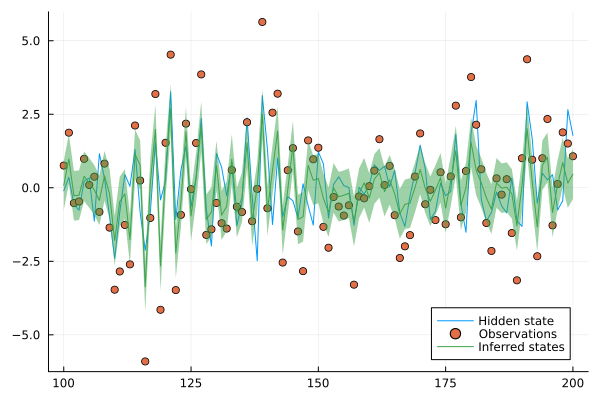

In [13]:
subrange = div(n,5):(div(n, 5) + div(n, 5))

plot(subrange, first.(states)[subrange], label="Hidden state")
scatter!(subrange, observations[subrange], label="Observations")
plot!(subrange, first.(mean.(x))[subrange], ribbon = sqrt.(first.(var.(x)))[subrange], label="Inferred states", legend = :bottomright)

It is also interesting to see where our AR coefficients converge to:

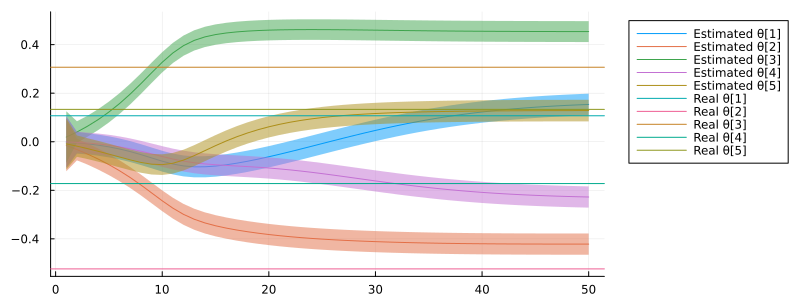

In [14]:
let
    pθ = plot()

    θms = mean.(θ)
    θvs = var.(θ)
    
    l = length(θms)

    edim(e) = (a) -> map(r -> r[e], a)

    for i in 1:length(first(θms))
        pθ = plot!(pθ, θms |> edim(i), ribbon = θvs |> edim(i) .|> sqrt, label = "Estimated θ[$i]")
    end
    
    for i in 1:length(real_θ)
        pθ = plot!(pθ, [ real_θ[i] ], seriestype = :hline, label = "Real θ[$i]")
    end
    
    plot(pθ, legend = :outertopright, size = (800, 300))
end

In [15]:
println("$(length(real_θ))-order AR inference Bethe Free Energy: ", last(mresult.free_energy))

5-order AR inference Bethe Free Energy: 1024.0293468916152


We can also run a 1-order AR inference on 5-order AR data:

In [16]:
uorder  = 1
uartype = Univariate
uc      = ReactiveMP.ar_unit(uartype, uorder)
uconstraints = ar_constraints()
umeta        = ar_meta(uartype, uorder, ARsafe())

uoptions = (limit_stack_depth = 100, )

umodel         = lar_model(uartype, length(observations), uorder, uc, real_τ)
udata          = (y = observations, )
uinitmarginals = (γ = GammaShapeRate(1.0, 1.0), θ = NormalMeanPrecision(0.0, 1.0))
ureturnvars    = (x = KeepLast(), γ = KeepEach(), θ = KeepEach())

uresult = inference(
    model = umodel, 
    data  = udata,
    meta  = umeta,
    constraints   = uconstraints,
    initmarginals = uinitmarginals,
    returnvars    = ureturnvars,
    free_energy   = true,
    iterations    = 50, 
    showprogress  = false
);

In [17]:
println("1-order AR inference Bethe Free Energy: ", last(uresult.free_energy))

1-order AR inference Bethe Free Energy: 1025.8792949319954


In [18]:
if uresult.free_energy[end] > mresult.free_energy[end]
    println("We can see that, according to final Bethe Free Energy value, in this example 5-order AR process can describe data better than 1-order AR.")
else
    error("AR-1 performs better than AR-5...") 
end

We can see that, according to final Bethe Free Energy value, in this example 5-order AR process can describe data better than 1-order AR.


# Autoregressive Moving Average Model

Bayesian [ARMA model](https://en.wikipedia.org/wiki/Autoregressive%E2%80%93moving-average_model#Applications) can be effectively implemeted in **RxInfer.jl**. For theoretical details on Varitional Inference for ARMA model, we refer the reader to the following [paper](https://ieeexplore.ieee.org/document/7798432). 
The Bayesian ARMA model can be written as follows:


$$\begin{aligned}
e_t \sim \mathcal{N}(0, \gamma^{-1}) \quad
\theta &\sim \mathcal{MN}(\mathbf{0}, \mathbf{I}) \quad
\eta \sim \mathcal{MN}(\mathbf{0}, \mathbf{I}) \\
\mathbf{h}_0 &\sim \mathcal{MN}\left(\begin{bmatrix}
e_{-1} \\
e_{-2}
\end{bmatrix}, \mathbf{I}\right) \\
\mathbf{h}_t &= \mathbf{S}\mathbf{h}_{t-1} + \mathbf{c} e_{t-1} \\
\mathbf{x}_t &= \boldsymbol{\theta}^\top\mathbf{x}_{t-1} + \boldsymbol{\eta}^\top\mathbf{h}_{t} + e_t 
\end{aligned}$$

where shift matrix $\mathbf{S}$ is

$$\begin{aligned}
\mathbf{S} = \begin{pmatrix}
0 & 0 \\
1 & 0 
\end{pmatrix}
\end{aligned}$$

and unit vector $\mathbf{c}$: 

$$\begin{aligned}
\mathbf{c}=[1, 0]
\end{aligned}$$ 

when MA order is $2$

In this way, $\mathbf{h}_t$ containing errors $e_t$ can be viewed as hidden state.

In short, the Bayesian ARMA model has two intractabilities: (1) induced by the multiplication of two Gaussian RVs, i.e., $\boldsymbol{\eta}^\top\mathbf{h}_{t}$, (2) induced by errors $e_t$ that prevents analytical update of precision parameter $\gamma$ (this can be easily seen when constructing the Factor Graph, i.e. there is a loop). Both problems can be easily resolved in **RxInfer.jl**, by creating a hybrid inference algorithm based on Loopy Variational Message Passing.

In [19]:
# Load packages
using RxInfer, LinearAlgebra, CSV, DataFrames, Plots

In [20]:
# Define shift function
function shift(dim)
    S = Matrix{Float64}(I, dim, dim)
    for i in dim:-1:2
           S[i,:] = S[i-1, :]
    end
    S[1, :] = zeros(dim)
    return S
end

shift (generic function with 1 method)

In [21]:
@model function ARMA(n, x_prev, h_prior, γ_prior, τ_prior, η_prior, θ_prior, p, q)
        
    c = zeros(p); c[1] = 1.0; # AR
    b = zeros(q); b[1] = 1.0; # MA
    S = shift(q); # MA
    
    # initialize variables
    h  = randomvar(n-1)
    e  = randomvar(n)
    z  = randomvar(n)
    
    x  = datavar(Float64, n) where { allow_missing = true }
    
    # priors
    γ  ~ Gamma(shape = shape(γ_prior), rate = rate(γ_prior))
    η  ~ MvNormal(mean = mean(η_prior), precision = precision(η_prior))
    θ  ~ MvNormal(mean = mean(θ_prior), precision = precision(θ_prior))
    τ  ~ Gamma(shape = shape(τ_prior), rate = rate(τ_prior))
    
    # initial
    h_0  ~ MvNormal(mean = mean(h_prior), precision = precision(h_prior))
    z[1] ~ AR(h_0, η, τ)
    e[1] ~ Normal(mean = 0.0, precision = γ)

    x[1] ~ dot(b, z[1]) + dot(θ, x_prev[1]) + e[1]
    
    h_prev = h_0
    for t in 1:n-1
        
        e[t+1] ~ Normal(mean = 0.0, precision = γ)
        h[t]   ~ S*h_prev + b*e[t]
        z[t+1] ~ AR(h[t], η, τ)
        x[t+1] ~ dot(z[t+1], b) + dot(θ, x_prev[t]) + e[t+1]
        h_prev = h[t]
    end
end

To validate our model and inference, we will use American Airlines stock data downloaded from [Kaggle](https://www.kaggle.com/code/purvasingh/time-series-analysis-with-arma-and-arima/data?select=all_stocks_5yr.csv)

In [22]:
x_df = CSV.read("../data/arma/aal_stock.csv", DataFrame)

Row,date,open,high,low,close,volume,Name
,Date,Float64,Float64,Float64,Float64,Int64,String3
1,2013-02-08,15.07,15.12,14.63,14.75,8407500,AAL
2,2013-02-11,14.89,15.01,14.26,14.46,8882000,AAL
3,2013-02-12,14.45,14.51,14.1,14.27,8126000,AAL
4,2013-02-13,14.3,14.94,14.25,14.66,10259500,AAL
5,2013-02-14,14.94,14.96,13.16,13.99,31879900,AAL
6,2013-02-15,13.93,14.61,13.93,14.5,15628000,AAL
7,2013-02-19,14.33,14.56,14.08,14.26,11354400,AAL
8,2013-02-20,14.17,14.26,13.15,13.33,14725200,AAL
9,2013-02-21,13.62,13.95,12.9,13.37,11922100,AAL


In [23]:
# we will use "close" column
x_data = filter(!ismissing, x_df[:, 5]);

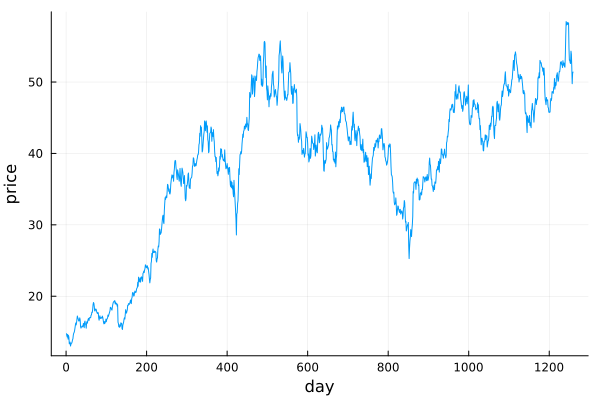

In [24]:
# Plot data
plot(x_data, xlabel="day", ylabel="price", label=false)

In [25]:
p_order = 10 # AR
q_order = 4 # MA

4

In [26]:
# Training set
train_size = 1000
x_prev_train = [Float64.(x_data[i+p_order-1:-1:i]) for i in 1:length(x_data)-p_order][1:train_size]
x_train = Float64.(x_data[p_order+1:end])[1:train_size];

In [27]:
# Test set
x_prev_test = [Float64.(x_data[i+p_order-1:-1:i]) for i in 1:length(x_data)-p_order][train_size+1:end]
x_test = Float64.(x_data[p_order+1:end])[train_size+1:end];

### Inference

In [28]:
# Constraints are needed for performing VMP
arma_constraints = @constraints begin
    q(z, h_0, h, η, τ, γ,e) = q(h_0)q(z, h)q(η)q(τ)q(γ)q(e)
end;

In [29]:
# This cell defines prior knowledge for model parameters
h_prior = MvNormalMeanPrecision(zeros(q_order), diageye(q_order))
γ_prior = GammaShapeRate(1e4, 1.0)
τ_prior = GammaShapeRate(1e2, 1.0)
η_prior = MvNormalMeanPrecision(zeros(q_order), diageye(q_order))
θ_prior = MvNormalMeanPrecision(zeros(p_order), diageye(p_order));

In [30]:
# Model's graph has structural loops, hence, it requires pre-initialisation
arma_imarginals = (h_0 = h_prior, h = h_prior, γ = γ_prior, τ = τ_prior, η = η_prior, θ = θ_prior);
arma_imessages  = (h_0 = h_prior, h = h_prior);
arma_meta       = ar_meta(Multivariate, q_order, ARsafe());

In [31]:
result = inference(
    model = ARMA(length(x_train), x_prev_train, h_prior, γ_prior, τ_prior, η_prior, θ_prior, p_order, q_order), 
    data  = (x = x_train, ),
    initmarginals = arma_imarginals,
    initmessages  = arma_imessages,
    constraints   = arma_constraints,
    meta          = arma_meta,
    iterations    = 50,
    options       = (limit_stack_depth = 400, ),
);

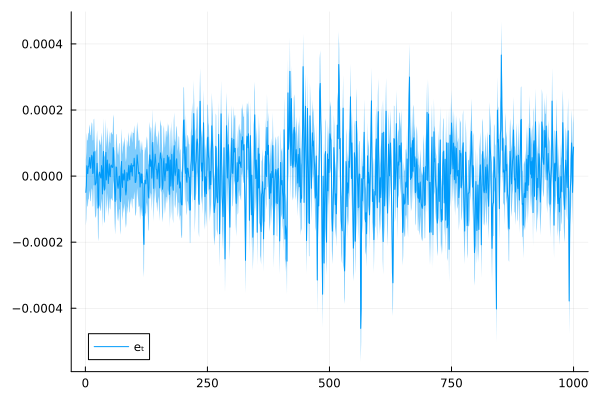

In [32]:
plot(mean.(result.posteriors[:e][end]), ribbon = var.(result.posteriors[:e][end]), label = "eₜ")

In [33]:
# extract posteriors
h_posterior = result.posteriors[:h][end][end]
γ_posterior = result.posteriors[:γ][end]
τ_posterior = result.posteriors[:τ][end]
η_posterior = result.posteriors[:η][end]
θ_posterior = result.posteriors[:θ][end];

## Prediction

Here we are going to use our inference results in order to predict the dataset itself

In [34]:
# The prediction function is aimed at approximating the predictive posterior distribution
# It triggers the rules in the generative order (in future, RxInfer.jl will provide this function out of the box)
function prediction(x_prev, h_posterior, γ_posterior, τ_posterior, η_posterior, θ_posterior, p, q)
    h_out = MvNormalMeanPrecision(mean(h_posterior), precision(h_posterior))
    ar_out = @call_rule AR(:y, Marginalisation) (m_x=h_out, q_θ=η_posterior, q_γ=τ_posterior, meta=ARMeta(Multivariate, p, ARsafe()))
    c = zeros(p); c[1] = 1.0
    b = zeros(q); b[1] = 1.0
    ar_dot_out = @call_rule typeof(dot)(:out, Marginalisation) (m_in1=PointMass(b), m_in2=ar_out)
    θ_out = MvNormalMeanPrecision(mean(θ_posterior), precision(θ_posterior))
    ma_dot_out = @call_rule typeof(dot)(:out, Marginalisation) (m_in1=PointMass(x_prev), m_in2=θ_out)
    e_out = @call_rule NormalMeanPrecision(:out, Marginalisation) (q_μ=PointMass(0.0), q_τ=mean(γ_posterior))
    ar_ma = @call_rule typeof(+)(:out, Marginalisation) (m_in1=ar_dot_out, m_in2=ma_dot_out)  
    @call_rule typeof(+)(:out, Marginalisation) (m_in1=ar_ma, m_in2=e_out)  
end

prediction (generic function with 1 method)

In [35]:
predictions = []
for x_prev in x_prev_test
    push!(predictions, prediction(x_prev, h_posterior, γ_posterior, τ_posterior, η_posterior, θ_posterior, p_order, q_order))
    # after every new prediction we can actually "retrain" the model to use the power of Bayesian approach
    # we will skip this part at this notebook
end

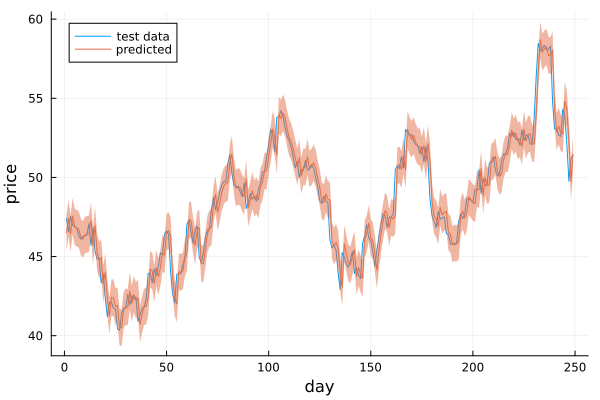

In [36]:
plot(x_test, label="test data", legend=:topleft)
plot!(mean.(predictions)[1:end], ribbon=std.(predictions)[1:end], label="predicted", xlabel="day", ylabel="price")